# Preparação do estado de bit-phase-flip

In [1]:
#from sympy import conjugate
from torch.autograd import Variable
import torch
from rsvg import rsvg
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
from tools import *
import sys
import pickle
import os
import cmath
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere


In [2]:
import qiskit
from qiskit import *
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from coherence import coh_l1
from pTrace import pTraceR

# pra iniciar ambiente da tomografia
nshots = 8192
IBMQ.save_account('7cc830e0cb005ce6de9caf9c402a1992c5d38d25af4237c19e72a4c58ce204481eb7a0d08b9929e5b5d3028f3146c38d2da8f2eb8db8f6f8b02a97eeb8fbc6de')
IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub='ibm-q', group='open', project='main')
device = provider.get_backend('ibmq_quito')
simulator = Aer.get_backend('qasm_simulator')

/tmp/ipykernel_52470/3847348147.py:4: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
configrc.store_credentials:WARNING:2023-02-16 21:57:30,051: Credentials already present. Set overwrite=True to overwrite.


In [5]:
# Para fazer o processo para cada valor de p
list_p = np.linspace(0,1,10)
n_qubits = 2
coerencias = []
for p in list_p:
    print(f'p = {p} de {len(list_p)}')
    circuit, params = vqa_bpf(n_qubits)
    target_vector, target_op = init_state_bpf(n_qubits, p)
    best_params, f = train(100, circuit, params, target_op)

    qr = QuantumRegister(2); qc = qiskit.QuantumCircuit(qr)
    #print(params.detach().numpy()[0])
    parametros = best_params.detach().numpy()
    #print(len(parametros))
    for i in range(0,24,6):
        #print(i)
        qc.rx(parametros[i],0)
        qc.ry(parametros[i+1],0)
        qc.rz(parametros[i+2],0)
        
        qc.rx(parametros[i+3],1)
        qc.ry(parametros[i+4],1)
        qc.rz(parametros[i+5],1)
        if i < 15:
            qc.cnot(0,1)
    qstc = state_tomography_circuits(qc, [qr[0],qr[1]])
    nshots = 8192
    job = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
    qstf = StateTomographyFitter(job.result(), qstc)
    rho = qstf.fit(method='lstsq')
    rhoA = pTraceR(2, 2, rho)
    cA = coh_l1(rhoA)
    coerencias.append(cA)
    
    

p = 0.0 de 10
0 0.6319007873535156
1 0.2648630142211914
2 0.06900882720947266
3 0.050889015197753906
4 0.053566932678222656
5 0.044083595275878906
6 0.035892486572265625
7 0.042057037353515625
8 0.0337066650390625
9 0.032639503479003906
10 0.024720191955566406
11 0.015870094299316406
12 0.013054847717285156
13 0.006890296936035156
14 0.004540443420410156
15 0.006257057189941406
16 0.006890296936035156
17 0.010117530822753906
18 0.017380714416503906
19 0.013278961181640625
20 0.018161773681640625
21 0.010715484619140625
22 0.008248329162597656
23 0.004029273986816406
24 0.0024805068969726562
25 0.0014505386352539062
26 0.00054931640625
27 0.00042057037353515625
28 0.00016117095947265625
29 0.00021457672119140625
30 0.0003814697265625
31 0.0003814697265625
32 0.00027561187744140625
33 0.0005960464477539062
34 0.0006952285766601562
35 0.000461578369140625
36 0.00042057037353515625
37 0.001102447509765625
38 0.0008020401000976562
39 0.0005960464477539062
40 0.000644683837890625
41 0.000308

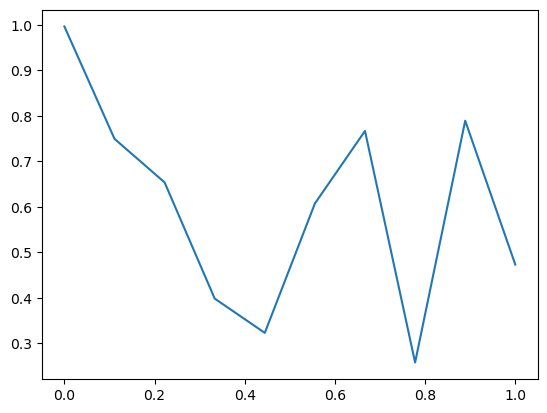

In [6]:
plt.plot(list_p,coerencias)
plt.show()

In [2]:
n_qubits = 2
circuit, params = vqa_bpf(n_qubits)
target_vector, target_op = init_state_bpf(n_qubits, 0.5)
best_params, f = train(10, circuit, params, target_op)


0
6
12
18
0
6
12
18
0 0.6909944993398751
0
6
12
18
0
6
12
18
1 0.23358050488672522
0
6
12
18
0
6
12
18
2 0.027468611210303397
0
6
12
18
0
6
12
18
3 0.0004021987203293613
0
6
12
18
0
6
12
18
4 0.006878889446596353
0
6
12
18
0
6
12
18
5 0.023137959085103906
0
6
12
18
0
6
12
18
6 0.039710445917620615
0
6
12
18
0
6
12
18
7 0.03604005076515831
0
6
12
18
0
6
12
18
8 0.03524857329699104
0
6
12
18
0
6
12
18
9 0.008340004986523592
0
6
12
18
9 0.008340004986523592


In [5]:
with open('params_nqb-2_BPF1.pkl', 'wb') as a:
        pickle.dump(best_params, a)

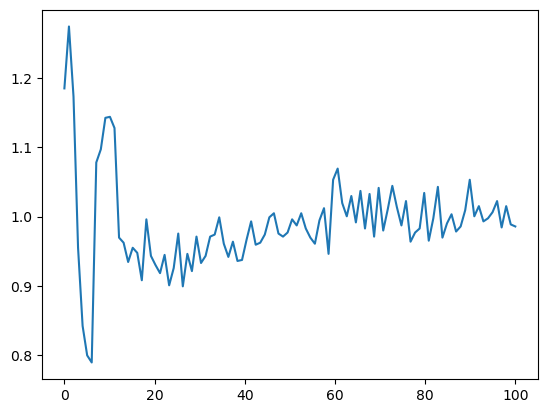

In [7]:
x = np.linspace(0,len(f),len(f))
plt.plot(x,f)
plt.show()

In [ ]:
#from qiskit_experiments.library import StateTomography
#from qiskit.providers.aer import AerSimulator

#beckend = Aer.get_backend('qasm_simulator')

In [4]:
import qiskit
from qiskit import *

nshots = 8192
IBMQ.save_account('7cc830e0cb005ce6de9caf9c402a1992c5d38d25af4237c19e72a4c58ce204481eb7a0d08b9929e5b5d3028f3146c38d2da8f2eb8db8f6f8b02a97eeb8fbc6de')
IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub='ibm-q', group='open', project='main')
device = provider.get_backend('ibmq_quito')
simulator = Aer.get_backend('qasm_simulator')
from qiskit.tools.monitor import job_monitor

configrc.store_credentials:WARNING:2023-02-16 13:50:42,213: Credentials already present. Set overwrite=True to overwrite.


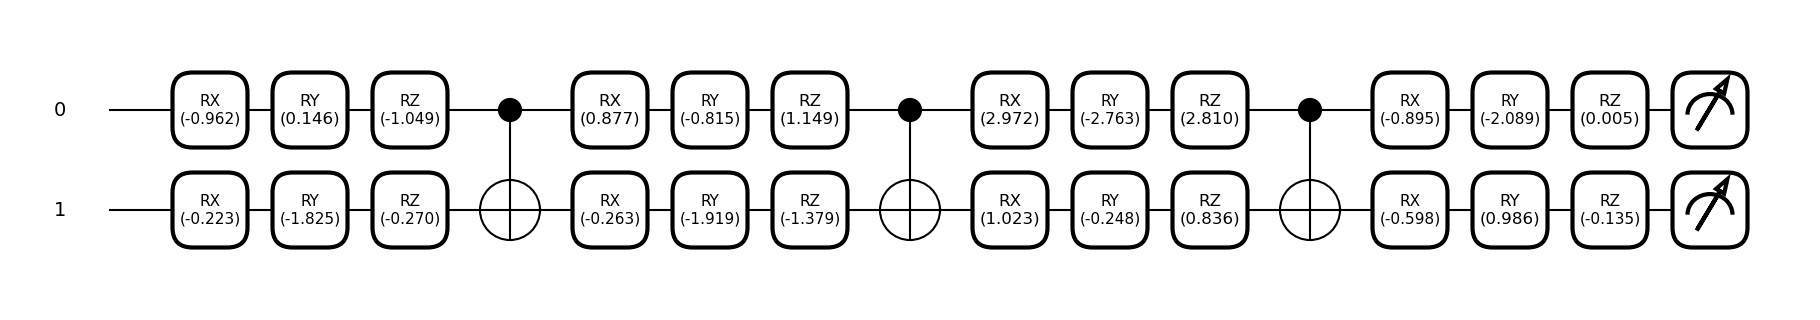

In [5]:
fig, ax = qml.draw_mpl(circuit, decimals=3)(best_params, target_op)
plt.show()

In [5]:
with open('Fidelidades_nqb-2_BPF1.pkl', 'rb') as f:
    best_params = pickle.load(f)
print(best_params)
print(len(best_params))

[0.927734375, 0.855494463683659, 0.8702003958155392, 1.0191127527212536, 0.9517138227461606, 0.9409092496643845, 1.0065191186412212, 0.98227962435546, 1.0187024483354241, 0.9370857539779589]
10


In [6]:

qr = QuantumRegister(2); qc = qiskit.QuantumCircuit(qr)
#print(params.detach().numpy()[0])
parametros = best_params.detach().numpy()
#print(len(parametros))
aux = 0
for i in range(0,24,6):
    #print(i)
    qc.rx(parametros[i],0)
    qc.ry(parametros[i+1],0)
    qc.rz(parametros[i+2],0)
    
    qc.rx(parametros[i+3],1)
    qc.ry(parametros[i+4],1)
    qc.rz(parametros[i+5],1)
    if i < 15:
        qc.cnot(0,1)
print(qc)

         ┌─────────────┐┌─────────────┐┌─────────────┐      ┌─────────────┐»
q3006_0: ┤ Rx(-1.6941) ├┤ Ry(0.99811) ├┤ Rz(0.38481) ├───■──┤ Rx(-1.8857) ├»
         └┬────────────┤├─────────────┤├─────────────┴┐┌─┴─┐├─────────────┤»
q3006_1: ─┤ Rx(-1.682) ├┤ Ry(0.43213) ├┤ Rz(-0.40637) ├┤ X ├┤ Rx(-1.6498) ├»
          └────────────┘└─────────────┘└──────────────┘└───┘└─────────────┘»
«         ┌─────────────┐┌──────────────┐     ┌──────────────┐┌──────────────┐»
«q3006_0: ┤ Ry(0.49786) ├┤ Rz(-0.22203) ├──■──┤ Rx(-0.75343) ├┤ Ry(-0.57589) ├»
«         └┬────────────┤├─────────────┬┘┌─┴─┐├─────────────┬┘└┬────────────┬┘»
«q3006_1: ─┤ Ry(3.6016) ├┤ Rz(0.55605) ├─┤ X ├┤ Rx(-1.5708) ├──┤ Ry(1.7203) ├─»
«          └────────────┘└─────────────┘ └───┘└─────────────┘  └────────────┘ »
«         ┌─────────────┐      ┌──────────┐ ┌──────────────┐┌─────────────┐
«q3006_0: ┤ Rz(0.27613) ├──■───┤ Rx(-2.3) ├─┤ Ry(-0.59026) ├┤ Rz(0.66193) ├
«         └┬────────────┤┌─┴─┐┌┴──────────┴┐├─────────────┬┘└┬─

In [7]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
qstc = state_tomography_circuits(qc, [qr[0],qr[1]])
nshots = 8192
job = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
qstf = StateTomographyFitter(job.result(), qstc)
rho = qstf.fit(method='lstsq')

rho

/tmp/ipykernel_9902/279195587.py:1: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


array([[ 0.23619292+0.j        ,  0.00164284-0.19283577j,
         0.1535461 -0.15495861j, -0.03003643+0.30476647j],
       [ 0.00164284+0.19283577j,  0.16018522+0.j        ,
         0.12866416+0.12690952j, -0.24953351-0.0247586j ],
       [ 0.1535461 +0.15495861j,  0.12866416-0.12690952j,
         0.20443277+0.j        , -0.22193469+0.17796983j],
       [-0.03003643-0.30476647j, -0.24953351+0.0247586j ,
        -0.22193469-0.17796983j,  0.39918909+0.j        ]])

In [8]:
def pTraceR(dl, dr, rhoLR):
    # Returns the right partial trace over the 'right' subsystem of rhoLR
    rhoA = np.zeros((dl, dl), dtype=complex)
    for j in range(0, dl):
        for k in range(j, dl):
            for l in range(0, dr):
                rhoA[j][k] += rhoLR[j*dr+l][k*dr+l]
        if j != k:
            rhoA[k][j] = np.conj(rhoA[j][k])
    return rhoA

In [9]:
rhoA = pTraceR(2, 2, rho)
rhoA

In [12]:
import math
def coh_l1(rho):  # normalized to [0,1]
    d = rho.shape[0]
    coh = 0.0
    for j in range(0, d-1):
        for k in range(j+1, d):
            coh += math.sqrt((rho[j][k].real)**2.0 + (rho[j][k].imag)**2.0)
    return 2.0*coh/(d-1)
cA = coh_l1(rhoA)
cA

0.40748919009876183

In [4]:
theta = np.linspace(0,np.pi,3)
phi = np.linspace(0,np.pi/2,3)

n = 10
n_qubits = 2
fidelidades = []
pes = np.linspace(0,1,n)
for i in range(0, n):
    circuit, params = vqa(n_qubits)
    target_vector, target_op = init_state_bpf(n_qubits, pes[i])
    best_params, f = train(15, circuit, params, target_op)
    fidelidades.append(f[-1])
    with open('Fidelidades_nqb-2_BPF1.pkl', 'wb') as a:
        pickle.dump(fidelidades, a)

0 0.8019342422485352
1 0.5595741271972656
2 0.3142127990722656
3 0.1341104507446289
4 0.0710763931274414
5 0.038529396057128906
6 0.020328521728515625
7 0.011962890625
8 0.005364418029785156
9 0.005222320556640625
10 0.006257057189941406
11 0.004281044006347656
12 0.002780914306640625
13 0.004029273986816406
14 0.006890296936035156
14 0.006890296936035156
0 0.8566724702286012
1 0.4403098056526978
2 0.15728251109873542
3 0.0519254597707173
4 0.06638103638885748
5 0.053291235437159745
6 0.08723657758714508
7 0.06235286248592883
8 0.06235286248592883
9 0.038072063371966336
10 0.03924281638305612
11 0.025405915158662865
12 0.02263828808219481
13 0.018650248463363498
14 0.0145652710937793
14 0.0145652710937793
0 0.43186350771561444
1 0.15602020557962967
2 0.04137508943328821
3 0.035450685478142854
4 0.035450685478142854
5 0.02692332324286987
6 0.016071792572261625
7 0.024341158830895982
8 0.016587188842029876
9 0.014091548013954465
10 0.01093928104186512
11 0.013150230047260335
12 0.0138531

In [8]:
x = np.linspace(0,len(f),len(f))
plt.plot(x,f)
plt.show()

TypeError: object of type '_io.BufferedReader' has no len()

10


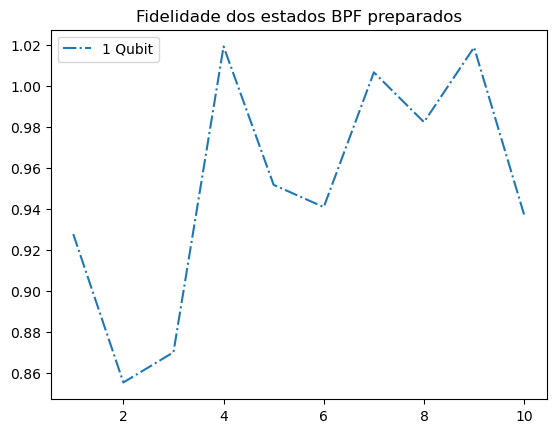

In [7]:
with open('Fidelidades_nqb-2_BPF1.pkl', 'rb') as f:
    y1 = pickle.load(f)
print(len(y1))
size = len(y1)
x = np.linspace(1, size, size)
plt.plot(x, y1[0:size], label='1 Qubit', linestyle="dashdot")
# plt.plot(x, y2[0:size], label='2 Qubit', linestyle=":")
# plt.plot(x, y3[0:size], label='3 Qubit', linestyle="--")
# plt.plot(x, y4[0:size], label='4 Qubit')
plt.title('Fidelidade dos estados BPF preparados')
#plt.ylim(0.95, 1.01)
plt.legend()
plt.show()

Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))


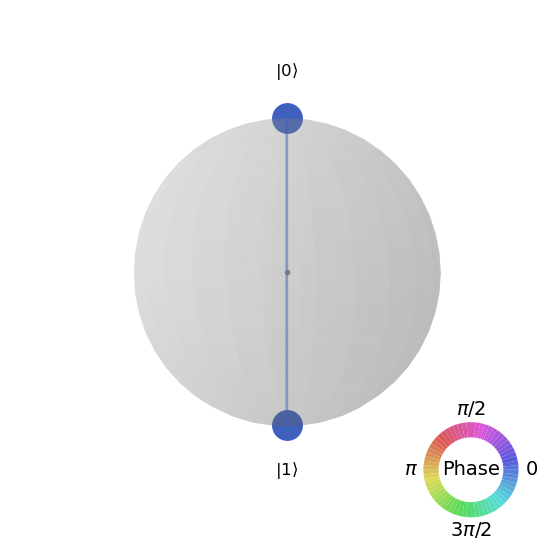

In [22]:
# TESTE COM O QISKIT
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere
sv=Statevector.from_label('+')
print(sv)
plot_state_qsphere(sv)

[0.70710678+0.j 0.70710678+0.j]


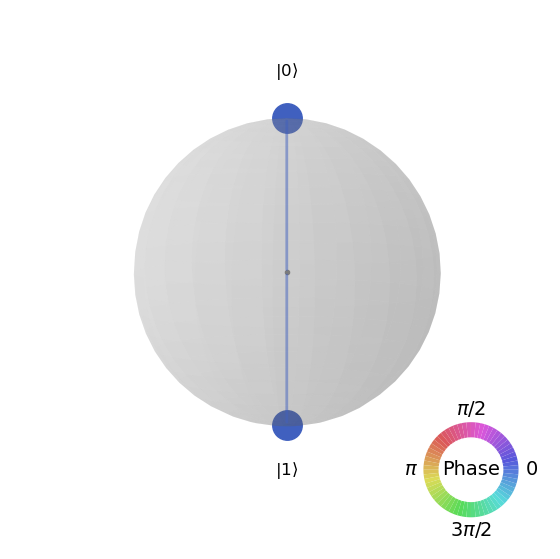

In [13]:
def general_state(theta, phi):
    state = np.zeros(2,dtype=complex)
    state[0] = np.cos(theta/2)
    state[1] = cmath.exp(1j*phi)*np.sin(theta/2)
    return state
print(general_state(np.pi/2,0))
sv=Statevector(general_state(np.pi/2,0))
plot_state_qsphere(sv)

In [9]:
import numpy as np
print(np.exp(np.float128(-10))) 
print(np.exp(np.float128(-10000)))

4.5399929762484851536e-05
1.1354838653147360985e-4343


In [5]:
def bpf(theta, phi, p):
    state = np.zeros(4,dtype=complex)
    state[0] = np.sqrt(1-p)*np.cos(theta/2)
    state[1] = cmath.exp(1j*phi)*np.sin(theta/2)
    state[2] = 1j*np.sqrt(p)*(-1)*cmath.exp(1j*phi)*np.sin(theta/2)
    state[3] = 1j*np.sqrt(p)*np.cos(theta/2)
    return state

print(bpf(np.pi/4,0,0.5))
#print(np.outer(bpf(np.pi/2,np.pi/4,0.5),bpf(np.pi/2,np.pi/4,0.5)))


[0.65328148+0.j         0.38268343+0.j         0.        -0.27059805j
 0.        +0.65328148j]


In [9]:
op = bpf(np.pi/1.5,0,0.5)
sv=Statevector(op)
plot_state_qsphere(sv)

QiskitError: 'Invalid input: not a vector or column-vector.'

NameError: name 'init_state_bpf' is not defined